In [2]:
import sys
sys.path.append("..")
from funcs.pcohp_funcs import get_cheap_pcohp
from helpers.ase_helpers import get_atoms
from helpers.data_parsers import parse_data
calc_path = "N2_calc"
data = parse_data(root=calc_path)
atoms = get_atoms(calc_path)
N_idcs = [i for i, el in enumerate(atoms.get_chemical_symbols()) if el == "N"]

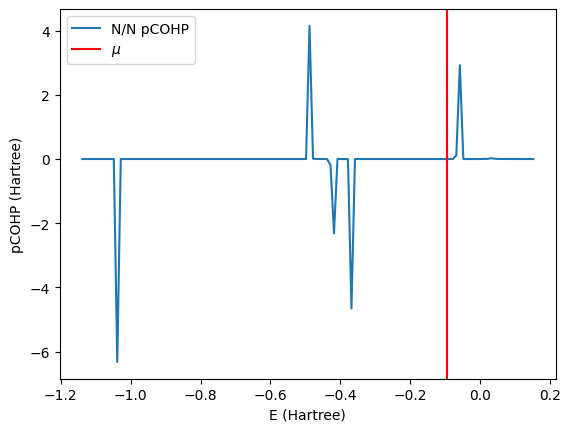

In [3]:
import matplotlib.pyplot as plt
Erange, ctot = get_cheap_pcohp([N_idcs[0]], [N_idcs[1]], calc_path, data=data)
plt.plot(Erange, ctot, label="N/N pCOHP")
mu = data[-1]
plt.axvline(x=mu, c="red", label="$\mu$")
plt.ylabel("pCOHP (Hartree)")
plt.xlabel("E (Hartree)")
plt.legend()

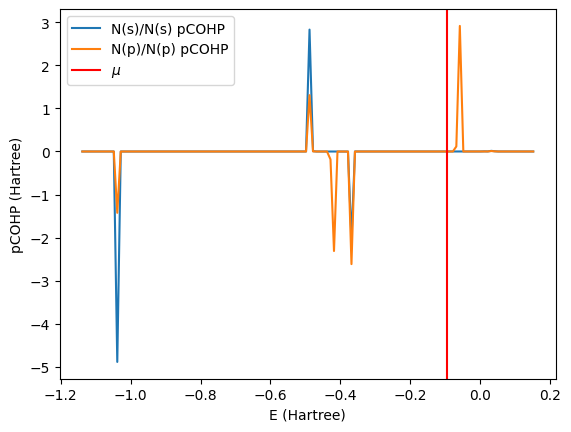

In [4]:
Erange, sigma_pcohp = get_cheap_pcohp([N_idcs[0]], [N_idcs[1]], calc_path, data=data, orbs1="s", orbs2="s")
Erange, pi_pcohp = get_cheap_pcohp([N_idcs[0]], [N_idcs[1]], calc_path, data=data, orbs1="p", orbs2="p")
plt.plot(Erange, sigma_pcohp, label="N(s)/N(s) pCOHP")
plt.plot(Erange, pi_pcohp, label="N(p)/N(p) pCOHP")
mu = data[-1]
plt.axvline(x=mu, c="red", label="$\mu$")
plt.ylabel("pCOHP (Hartree)")
plt.xlabel("E (Hartree)")
plt.legend()